# Practical 3: Feature Selection & Dimension Reduction
### Instructor: Dr. Maryam Movahedifar

<div style="display: flex; justify-content: space-between; align-items: center;">
  <span style="display: flex; align-items: center;">
    <b>Applied Text Mining - University of Bremen - Data Science Center</b>
  </span>
  <div style="display: flex; align-items: center; margin-left: auto;">
    <img src="Uni_Logo.png" alt="Uni Logo" style="width: 100px; margin-right: 10px;">
    <img src="DSC_Logo.png" alt="DSC Logo" style="width: 150px;">
  </div>
</div>


In this practical, we are going to learn about feature selection and dimension reduction methods for text data.

Today we will use the following libraries. Take care to have them installed!

In [1]:
!pip install -q scikit-learn -q numpy==1.24.0 gensim==4.3.3 spacy==3.5.1 nltk --upgrade

In [2]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


# Let's Get Started!

1. **Here we are going to use a news article dataset, originating from the BBC News website. This dataset was provided for benchmarking machine learning algorithms. The BBC dataset consists of 2,225 documents and 5 categories: business, entertainment, politics, sport, and tech. Upload the `data.zip` file and extract it using the code below.**


In [3]:
# for reproducibility
random_state = 321

# Unzip the bbc.zip file from the Text-Mining/data folder into the Text-Mining/answers folder
#!unzip ~/Text-Mining/data/bbc.zip -d ~/Text-Mining/Answers


**Load the dataset and convert it to a dataframe.**

In [4]:
data = load_files('bbc', encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

,text,label
0,Chris Evans back on the market\n\nBroadcaster ...,1
1,Giggs handed Wales leading role\n\nRyan Giggs ...,3
2,Wales silent on Grand Slam talk\n\nRhys Willia...,3
3,Kenya lift Chepkemei's suspension\n\nKenya's a...,3
4,Lee to create new film superhero\n\nComic book...,1


2. **Print the unique target names in your data and check the number of articles in each category. Then split your data into training (80%) and test (20%) sets.**

In [5]:
labels, counts = np.unique(df['label'], return_counts=True) # np.unique(data.target, return_counts=True)

In [6]:
print(dict(zip(data.target_names, counts)))

{'business': 510, 'entertainment': 386, 'politics': 417, 'sport': 511, 'tech': 401}


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=random_state)

In [8]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

1935    Moya emotional at Davis Cup win\n\nCarlos Moya...
523     Bryan twins keep US hopes alive\n\nThe United ...
1278    Christmas sales worst since 1981\n\nUK retail ...
130     Jones medals 'must go if guilty'\n\nWorld Anti...
905     Eminem secret gig venue revealed\n\nRapper Emi...
                              ...                        
984     Ferdinand casts doubt over Glazer\n\nRio Ferdi...
168     Harinordoquy suffers France axe\n\nNumber eigh...
1425    Tsunami cost hits Jakarta shares\n\nThe stock ...
1833    Federer breezes into semi-finals\n\nRoger Fede...
124     Player burn-out worries Robinson\n\nEngland co...
Name: text, Length: 1780, dtype: object
690     US composer recreates Bach score\n\nA US music...
1427    Warning over tsunami aid website\n\nNet users ...
1708    Nuclear strike 'key terror risk'\n\nThe UK and...
1325    McDonald's boss Bell dies aged 44\n\nCharlie B...
883     Retail sales show festive fervour\n\nUK retail...
                              ..

 3. **Use the `CountVectorizer` from `sklearn` and convert the text data into a document-term matrix. What is the difference between `CountVectorizer` and `TfidfVectorizer(use_idf=False)`?**


In [9]:
#tokenizer to remove unwanted elements from out data like symbols
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
# If you have memory issues, reduce the max_features value so you can continue with the practical
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=token.tokenize,
                             stop_words='english',
                             ngram_range=(1, 2),
                             analyzer='word',
                             min_df=3,
                             max_features=None)

# fit_transform() does two functions: First, it fits the model and learns the vocabulary;
# second, it transforms our data into feature vectors.
# The input to fit_transform should be a list of strings.
bbc_dtm = vectorizer.fit_transform(X_train)
print(bbc_dtm.shape)

/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1780, 25223)


The only difference is that the `TfidfVectorizer()` returns floats, while the `CountVectorizer()` returns integers. This is expected, as `TfidfVectorizer()` assigns a score based on term frequency-inverse document frequency (even with `use_idf=False`), while `CountVectorizer()` simply counts the occurrences of each term in each document.


4. **Print top 20 most frequent words in the training set.**

In [10]:
importance = np.argsort(np.asarray(bbc_dtm.sum(axis=0)).ravel())[::-1]
feature_names = np.array(vectorizer.get_feature_names_out())
feature_names[importance[:20]]

array(['s', 'said', 'mr', 'year', 'people', 'new', 't', 'time', 'world',
       'government', 'uk', 'years', 'best', 'just', 'told', 'film',
       'make', '1', 'game', 'like'], dtype=object)

## Filter-based Feature Selection
5. **From the feature selection library in `sklearn`, load the `SelectKBest` function and apply it to the BBC dataset using the chi-squared method. Extract the top 20 features.**


In [11]:
X_test_vectorized = vectorizer.transform(X_test)

In [12]:
ch2 = SelectKBest(chi2, k=20)
ch2.fit_transform(bbc_dtm, y_train)

<1780x20 sparse matrix of type '<class 'numpy.int64'>'
	with 4428 stored elements in Compressed Sparse Row format>

In [13]:
feature_names_chi = [feature_names[i] for i
                         in ch2.get_support(indices=True)]

In [14]:
feature_names_chi

['best',
 'blair',
 'brown',
 'computer',
 'digital',
 'election',
 'film',
 'government',
 'labour',
 'minister',
 'mobile',
 'mr',
 'mr blair',
 'music',
 'net',
 'party',
 'people',
 'software',
 'technology',
 'users']

6. **Repeat the analysis in Question 5 with the mutual information feature selection method. Do you get the same list of words as compared to the chi-squared method?**

In [15]:
mutual_info = SelectKBest(mutual_info_classif, k=20)
mutual_info.fit_transform(bbc_dtm, y_train)

<1780x20 sparse matrix of type '<class 'numpy.int64'>'
	with 6350 stored elements in Compressed Sparse Row format>

In [16]:
feature_names_mutual_info = [feature_names[i] for i
                         in mutual_info.get_support(indices=True)]
feature_names_mutual_info

['blair',
 'coach',
 'election',
 'film',
 'firm',
 'game',
 'government',
 'labour',
 'market',
 'minister',
 'mr',
 'music',
 'party',
 'people',
 'said',
 'secretary',
 'technology',
 'tory',
 'users',
 'win']

Now you can build a classifier and train it using the output of these feature selection techniques. We are not going to do this right now, but if you are interested you can transform your training and test set using the selected features and continue with your classifier! Here are some tips:

In [17]:
 #X_train = mutual_info.fit_transform(bbc_dtm, y_train)
# X_test = mutual_info.transform(X_test_vectorized)

## Embedded Feature Selection
7. **One of the functions for embedded feature selection is the `SelectFromModel` function in `sklearn`. Use this function with an L1 norm SVM and check how many non-zero coefficients remain in the model.**


In [32]:
print("shape of the matrix before applying the embedded feature selection:", bbc_dtm.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False) #C=0.01 is a regularization parameter. A smaller C (stronger regularization) penalizes large coefficients more heavily, pushing more coefficients towards zero.
model = SelectFromModel(lsvc).fit(bbc_dtm, y_train) # you can add threshold=0.18 as another argument to select features that have an importance of more than 0.18
X_new = model.transform(bbc_dtm)
print("shape of the matrix after applying the embedded feature selection:", X_new.shape)

shape of the matrix before applying the embedded feature selection: (1780, 25223)
shape of the matrix after applying the embedded feature selection: (1780, 154)


In [29]:
model

SelectFromModel(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'))

In [30]:
# you can also check the coefficient values
a = model.estimator_.coef_

In [31]:
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
a.shape

(5, 25223)

8. **What are the top features according to the SVM model? Tip: Use the function `model.get_support()` to find these features.**


In [36]:
model.get_support()

array([False, False, False, ..., False, False, False])

In [37]:
print("Features selected by SelectFromModel: ", feature_names[model.get_support()])

Features selected by SelectFromModel:  ['000' '1' '2' '2004' '6' 'airlines' 'album' 'analysts' 'apple' 'athens'
 'athletics' 'award' 'ballet' 'ban' 'band' 'bank' 'bbc' 'best' 'bid'
 'blair' 'blog' 'book' 'britain' 'broadband' 'brown' 'business' 'champion'
 'chart' 'chelsea' 'chief' 'children' 'china' 'club' 'coach' 'comedy'
 'companies' 'company' 'computer' 'conte' 'content' 'council' 'cup' 'data'
 'deal' 'digital' 'dollar' 'doping' 'drugs' 'e' 'economic' 'economy'
 'education' 'election' 'england' 'eu' 'european' 'euros' 'film'
 'financial' 'firm' 'firms' 'fraud' 'game' 'games' 'gaming' 'glazer'
 'good' 'government' 'group' 'growth' 'high' 'home' 'howard' 'iaaf'
 'information' 'injury' 'just' 'labour' 'league' 'like' 'liverpool' 'lord'
 'm' 'make' 'market' 'match' 'microsoft' 'million' 'minister' 'mobile'
 'mps' 'mr' 'music' 'musical' 'net' 'new' 'nintendo' 'number' 'o' 'oil'
 'old' 'olympic' 'online' 'party' 'people' 'plans' 'play' 'players'
 'police' 'president' 'prices' 'public' 'r

## Model comparison
9. **Create a pipeline with the tfidf representation and a random forest classifier.**

In [38]:
clf1 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('classification', RandomForestClassifier())
])

In [39]:
clf1

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('classification', RandomForestClassifier())])

10. **Fit the pipeline on the training set.**

In [40]:
clf1.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('classification', RandomForestClassifier())])

11. **Use the pipeline to predict the outcome variable on your test set. Evaluate the performance of the pipeline using the `classification_report` function on the test subset.  
    Question: How do you interpret your results?**


In [41]:
y_pred1 = clf1.predict(X_test)
print(metrics.classification_report(y_test, y_pred1, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.92      0.96      0.94        92
entertainment       0.99      0.92      0.95        84
     politics       0.92      0.90      0.91        77
        sport       0.94      0.98      0.96       111
         tech       0.97      0.96      0.97        81

     accuracy                           0.95       445
    macro avg       0.95      0.94      0.94       445
 weighted avg       0.95      0.95      0.95       445



In [42]:
y_pred1

array([1, 4, 4, 0, 0, 3, 2, 0, 1, 1, 2, 3, 3, 4, 0, 2, 3, 3, 3, 4, 2, 0,
       1, 4, 2, 3, 0, 1, 4, 0, 2, 4, 4, 0, 3, 4, 2, 0, 0, 0, 3, 0, 2, 3,
       1, 4, 3, 4, 3, 2, 1, 1, 1, 0, 0, 0, 3, 0, 2, 0, 4, 3, 3, 2, 0, 4,
       4, 1, 3, 4, 3, 1, 1, 0, 3, 0, 0, 2, 2, 0, 4, 1, 3, 4, 4, 4, 3, 4,
       4, 1, 1, 2, 2, 1, 1, 3, 0, 4, 3, 2, 2, 3, 1, 0, 3, 3, 2, 4, 2, 1,
       4, 3, 0, 4, 1, 4, 3, 3, 0, 3, 1, 4, 2, 3, 2, 2, 2, 2, 0, 2, 3, 4,
       3, 2, 1, 3, 2, 3, 2, 4, 3, 1, 1, 0, 4, 0, 0, 0, 4, 4, 1, 3, 0, 4,
       3, 0, 4, 3, 0, 3, 1, 0, 1, 4, 2, 3, 1, 1, 4, 2, 1, 3, 0, 0, 3, 0,
       1, 3, 2, 3, 3, 0, 0, 0, 1, 3, 0, 3, 0, 4, 2, 4, 1, 3, 2, 1, 3, 2,
       0, 3, 3, 0, 2, 1, 2, 2, 3, 3, 2, 4, 2, 1, 1, 0, 0, 2, 3, 1, 1, 3,
       0, 1, 4, 4, 3, 4, 0, 3, 3, 4, 2, 1, 2, 3, 3, 0, 1, 4, 3, 1, 1, 3,
       1, 3, 4, 0, 2, 3, 3, 1, 1, 0, 0, 3, 3, 4, 3, 3, 2, 3, 0, 0, 3, 1,
       0, 1, 2, 1, 1, 0, 1, 2, 3, 2, 0, 4, 2, 2, 0, 1, 3, 0, 4, 4, 0, 2,
       0, 1, 4, 3, 3, 1, 1, 1, 4, 1, 4, 2, 3, 4, 0,

In [28]:
clf2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', RandomForestClassifier())
])

In [29]:
clf2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', RandomForestClassifier())])

In [30]:
y_pred2 = clf2.predict(X_test)

In [31]:
print(metrics.classification_report(y_test, y_pred2, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.92      0.92      0.92        92
entertainment       0.96      0.92      0.94        84
     politics       0.90      0.90      0.90        77
        sport       0.97      0.98      0.98       111
         tech       0.94      0.98      0.96        81

     accuracy                           0.94       445
    macro avg       0.94      0.94      0.94       445
 weighted avg       0.94      0.94      0.94       445



13. **Create your third and fourth pipelines with the tfidf representation, a chi2 feature selection (with 20 and 200 features for `clf3` and `clf4`, respectively), and a random forest classifier.**


In [32]:
clf3 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=20)),
    ('classification', RandomForestClassifier())
])

In [33]:
clf3.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectKBest(k=20,
                             score_func=<function chi2 at 0x7f0d31cbe2a0>)),
                ('classification', RandomForestClassifier())])

In [34]:
y_pred3 = clf3.predict(X_test)
print(metrics.classification_report(y_test, y_pred3, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.64      0.46      0.53        92
entertainment       0.81      0.57      0.67        84
     politics       0.77      0.73      0.75        77
        sport       0.63      0.99      0.77       111
         tech       0.89      0.79      0.84        81

     accuracy                           0.72       445
    macro avg       0.75      0.71      0.71       445
 weighted avg       0.74      0.72      0.71       445



In [35]:
clf4 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=200)),
    ('classification', RandomForestClassifier())
])

In [36]:
clf4.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectKBest(k=200,
                             score_func=<function chi2 at 0x7f0d31cbe2a0>)),
                ('classification', RandomForestClassifier())])

In [37]:
y_pred4 = clf4.predict(X_test)
print(metrics.classification_report(y_test, y_pred4, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.86      0.91      0.88        92
entertainment       0.97      0.90      0.94        84
     politics       0.93      0.90      0.91        77
        sport       0.97      0.98      0.98       111
         tech       0.93      0.95      0.94        81

     accuracy                           0.93       445
    macro avg       0.93      0.93      0.93       445
 weighted avg       0.93      0.93      0.93       445



14. **We can change the learner by simply plugging a different classifier object into our pipeline. Create your fifth pipeline with L1 norm SVM for the feature selection method and naive Bayes for the classifier. Compare your results on the test set with the previous pipelines.**

In [38]:
clf5 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', MultinomialNB(alpha=0.01))
])

In [39]:
clf5.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', MultinomialNB(alpha=0.01))])

In [40]:
y_pred5 = clf5.predict(X_test)
print(metrics.classification_report(y_test, y_pred5, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.96      0.93      0.95        92
entertainment       1.00      0.94      0.97        84
     politics       0.95      0.99      0.97        77
        sport       1.00      1.00      1.00       111
         tech       0.93      0.98      0.95        81

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



## Optional: Dimension reduction
15. **Dimensionality reduction methods such as PCA and SVD can be used to project the data into a lower-dimensional space. If you run PCA with your text data, you might end up with the message:**

    "PCA does not support sparse input. See TruncatedSVD for a possible alternative."

    **Therefore, we will use the `TruncatedSVD` function from the sklearn package. We want to find out how much of the variance in the BBC dataset is explained with different components. To do this, first create a tfidf matrix and use that to make a co-occurrence matrix.**


In [41]:


# Initialize the TfidfVectorizer
tfidf_vect = TfidfVectorizer()

# Fit and transform the training data
X = tfidf_vect.fit_transform(X_train)

# Create the co-occurrence matrix
Xc = (X.T * X)  # This is the co-occurrence matrix in sparse csr format

# Set the diagonal to 0 (remove self-cooccurrences)
Xc.setdiag(0)

# Print the shape of the TFIDF matrix
print("Shape of the TFIDF vectorizer:", X.shape)


Shape of the TFIDF vectorizer: (1780, 26739)


16. **Run the TruncatedSVD function with different values for components: 1, 2, 4, 5, 10, 15, 20, 50, 100. Plot the explained variance ratio for each component of Truncated SVD.**

Number of components = 1 and explained variance = 0.8302335701200985
Number of components = 2 and explained variance = 0.9165093632208278
Number of components = 4 and explained variance = 0.9291569440571865
Number of components = 5 and explained variance = 0.934486055353985
Number of components = 10 and explained variance = 0.9477460365510294
Number of components = 15 and explained variance = 0.9529731073724196
Number of components = 20 and explained variance = 0.9560375991471992
Number of components = 50 and explained variance = 0.9645814066707996
Number of components = 100 and explained variance = 0.9711191624492495


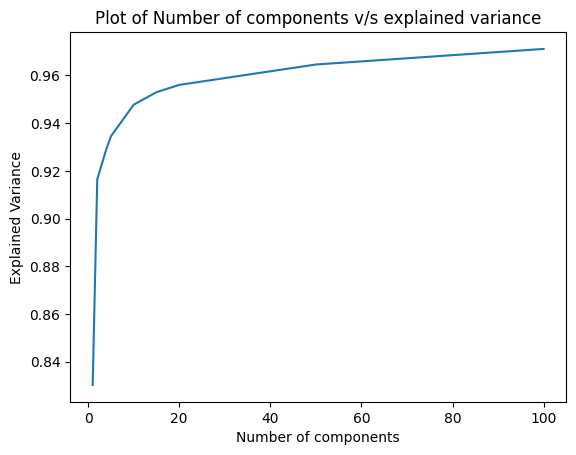

In [42]:
n_comp = [1, 2, 4, 5, 10, 15, 20, 50, 100] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x, random_state=321)
    svd.fit(Xc)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [43]:
clf6 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_extraction', TfidfTransformer()),
    ('feature_selection', TruncatedSVD(n_components=15, random_state=321)),
    ('classification', LinearSVC())
])

In [44]:
clf6.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('feature_extraction', TfidfTransformer()),
                ('feature_selection',
                 TruncatedSVD(n_components=15, random_state=321)),
                ('classification', LinearSVC())])

In [45]:
y_pred6 = clf6.predict(X_test)
print(metrics.classification_report(y_test, y_pred6, target_names=data.target_names))

               precision    recall  f1-score   support

     business       0.91      0.92      0.92        92
entertainment       1.00      0.94      0.97        84
     politics       0.91      0.92      0.92        77
        sport       0.99      1.00      1.00       111
         tech       0.94      0.96      0.95        81

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445

